## Analysis of Bumble reviews 

In this notebook I will look at the data about the Bumble app on play store. The dataset has been downloaded from kaggle. author: SHIV KUMAR GANESH, version: 117, extracted date: 21/05/2024, URL:https://www.kaggle.com/datasets/shivkumarganesh/bumble-dating-app-google-play-store-review/data?select=bumble_google_play_reviews.csv


In [1]:
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

### Exploring the dataset

In [2]:
#reading the csv file
df = pd.read_csv('bumble_google_play_reviews.csv', encoding='utf-8')

In [3]:
#database dimensionality
print('The database has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

The database has 104877 rows and 10 columns


In [6]:
#look at column object type and null values
display(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104877 entries, 0 to 104876
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              104877 non-null  object
 1   userName              104876 non-null  object
 2   userImage             104877 non-null  object
 3   content               104868 non-null  object
 4   score                 104877 non-null  int64 
 5   thumbsUpCount         104877 non-null  int64 
 6   reviewCreatedVersion  88213 non-null   object
 7   at                    104877 non-null  object
 8   replyContent          60798 non-null   object
 9   repliedAt             60798 non-null   object
dtypes: int64(2), object(8)
memory usage: 8.0+ MB


None

In [7]:
#calculate the number and percentage of null values per column
dt_cnt = []
dt_perc = []
col = []
for c in df.columns:
    data_count = df[c].isnull().sum()
    data_percentage = df[c].isnull().sum()/len(df[c])
    dt_cnt.append(data_count)
    dt_perc.append(data_percentage)
    col.append(c)

print('Number of missing values:')
data = pd.DataFrame(columns=['Coloumn','Count', 'Percentage'])   
data['Coloumn'] = col
data['Count'] = dt_cnt
data['Percentage'] = dt_perc
data['Percentage'] = data['Percentage'].map('{:.2%}'.format)
display(data)

Number of missing values:


,Coloumn,Count,Percentage
0,reviewId,0,0.00%
1,userName,1,0.00%
2,userImage,0,0.00%
3,content,9,0.01%
4,score,0,0.00%
5,thumbsUpCount,0,0.00%
6,reviewCreatedVersion,16664,15.89%
7,at,0,0.00%
8,replyContent,44079,42.03%
9,repliedAt,44079,42.03%


The majority of columns are dtype object, two columns are int. The majority of columns have no missing values. The review version has some missing values. This might creates some issue if we want to look and comapare different versions of the app. Althout thare is only about the 16% of mising values. 
The other columns with missing values are the columns holding information about the reply to the review. A missing value means no reply was added to the review. 

Some columns holds dates, these columns types needs to be changed.
Some columns do not hold usefull data for the analysis, e.g. User Image, those columns will be removed.

In [8]:
#renaming columns to make it easier to understand
df = df.rename(columns={"at": "reviewDate", "repliedAt": "replyDate"})

#changing format to date
for f in df[['reviewDate', 'replyDate']]:
    df[f] = pd.to_datetime(df[f])

   

In [9]:
#look at unique names
len(df['userName'])-df['userName'].nunique()

10102

In [10]:
df['reviewId'].duplicated().sum()

0

There are duplicates in the names, but no duplicates in the review ID. many duplicate are 'A Google use', google should allow only one review per user, but people could have they same name. 

In [11]:
 #dropping columns that aren't needed
df = df.drop(columns= ['userName', 'reviewId', 'userImage'])

In [12]:
df.head(1)

,content,score,thumbsUpCount,reviewCreatedVersion,reviewDate,replyContent,replyDate
0,"You get a set number of likes per 24 hours, so...",1,0,5.201.1,2022-03-21 12:32:25,NaN,NaT


### Exploring the scores

In [13]:
for c in df.columns: 
    if df[c].dtype == 'int64':
        print(pd.DataFrame(df[c].describe()))
        print('')

               score
count  104877.000000
mean        2.829095
std         1.718701
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         5.000000

       thumbsUpCount
count  104877.000000
mean        2.732239
std        18.087150
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      1275.000000



The scores seem quite unifomally distributed. I will divide the scores into bad = 1 or 2, average = 3, good 4 or 5

In [14]:
#creating grouping and new coloumn with the grouping
grouping = {1: 'Bad', 2:'Bad', 3: 'Average', 4: 'Good', 5:'Good'}
df['groupScore'] = df['score'].map(grouping)

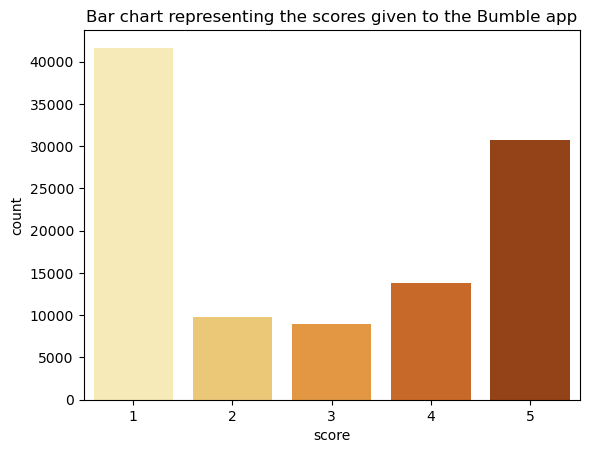

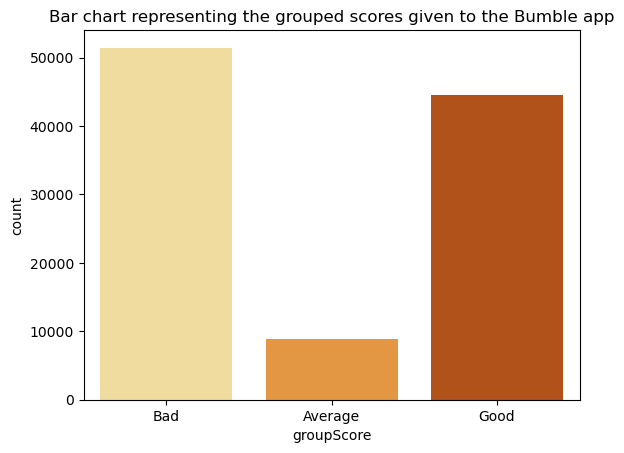

In [15]:
#plotting the scores
sns.countplot(df, x='score', palette = 'YlOrBr')
plt.title('Bar chart representing the scores given to the Bumble app')
plt.show()

order=['Bad', 'Average', 'Good']
sns.countplot(df, x='groupScore', palette = 'YlOrBr', order=order)
plt.title('Bar chart representing the grouped scores given to the Bumble app')
plt.show()

In [16]:
def dataframe(data, coloumn):
    '''this function create a dataframe with count and precentage of the values in a column.
    takes the dataframe and column name as argument
    '''
    score = pd.DataFrame(columns=['Count', 'Percentage'])   
    count_score = data[coloumn].value_counts()

    percentage = data[coloumn].value_counts()/ data[coloumn].count()
    score['Count'] = count_score
    score['Percentage'] = percentage
    score['Percentage'] = score['Percentage'].map('{:.2%}'.format)
    return score

In [17]:
#display the count and percentage for the score and grouped score
score1 = dataframe(df, 'score')
display(score1.sort_index())
score_group = dataframe(df, 'groupScore')
#order by group
score_group_ordered = score_group.reindex(index=order)
display(score_group_ordered)

,Count,Percentage
score,,
1,41633,39.70%
2,9818,9.36%
3,8941,8.53%
4,13810,13.17%
5,30675,29.25%


,Count,Percentage
groupScore,,
Bad,51451,49.06%
Average,8941,8.53%
Good,44485,42.42%


### Exploring the review replies and difference in time

In [18]:
#calculate difference between reply and review added
df['difference'] = df['replyDate'].dt.normalize() - df['reviewDate'].dt.normalize() 

In [19]:
df['difference'].describe()

count                         60798
mean      9 days 19:58:20.523043521
std      42 days 02:30:18.586011614
min            -1692 days +00:00:00
25%                 1 days 00:00:00
50%                 4 days 00:00:00
75%                13 days 00:00:00
max               796 days 00:00:00
Name: difference, dtype: object

There are a few replies a few years before the actual review. I'd assume that the review has been modified and the new date has been added or there has been an error. I'll only consider reviews with a difference of > 0 days

In [20]:
df_over = df.loc[df['difference']>= '0 days']

In [22]:
df_over['difference'].describe()

count                         60206
mean     11 days 18:16:45.268577882
std      26 days 01:54:16.425430781
min                 0 days 00:00:00
25%                 1 days 00:00:00
50%                 4 days 00:00:00
75%                13 days 00:00:00
max               796 days 00:00:00
Name: difference, dtype: object

In [23]:
print('The median time to answer to a reply is {}'.format(df['difference'].median()))

The median time to answer to a reply is 4 days 00:00:00


I'm now looking at the number of reply for scoring group

In [24]:
def dataframe_grouped(data, coloumn_group, coloumn_count):
    '''The function create a datafraem with count of values added percentage of one column grouped by another. 
    it takes the dataset, the grouping column, and the other column as argument
    '''
    score_gr = pd.DataFrame(columns=['Count', 'Percentage'])   
    count_score = df.groupby([coloumn_group])[coloumn_count].count()

    percentage = count_score/ data[coloumn_count].count()
    score_gr['Count'] = count_score
    score_gr['Percentage'] = percentage
    score_gr['Percentage'] = score_gr['Percentage'].map('{:.2%}'.format)
    return score_gr

In [25]:
#display the count and percentage of number of replies by scoring group
sc_gr = dataframe_grouped(df, 'groupScore', 'replyContent')
sc_gr_ordered = sc_gr.reindex(index=order)
display(sc_gr_ordered)

,Count,Percentage
groupScore,,
Bad,44811,73.70%
Average,6772,11.14%
Good,9215,15.16%


### Display the most common word used in the reviews

I'm creating a wrod cloud for the reviews considered bad (score of 1 or 2) and one for the reviews considered good and neutrl (score of 3 or higher)

In [29]:
#dividing the dataset in lower and higher scorer
bad = df.loc[df['groupScore'] == 'Bad']
good = df.loc[df['groupScore'] != 'Bad']

In [30]:
text_bad = str(bad['content'].values).lower()

In [32]:
text_good = str(good['content'].values).lower()


In [33]:
#add words to the stopwords
stop = STOPWORDS.update(['app', 'android'])

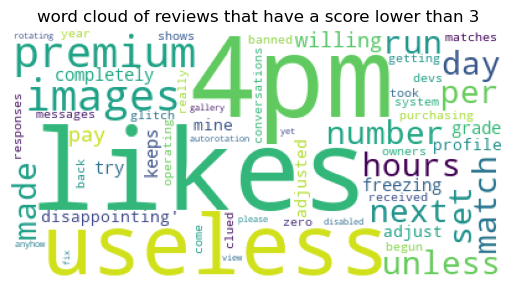

In [34]:
#create wordcloud
wordcloud_bad = WordCloud(stopwords = stop, max_words = 300, background_color='white').generate(text_bad)
plt.title('word cloud of reviews that have a score lower than 3')

plt.axis('off')
plt.imshow(wordcloud_bad)
plt.show()

The majority of bad comments seem to include issues with the likes, possible about the number of like you get in the 24hr, and that the app is not useful. 

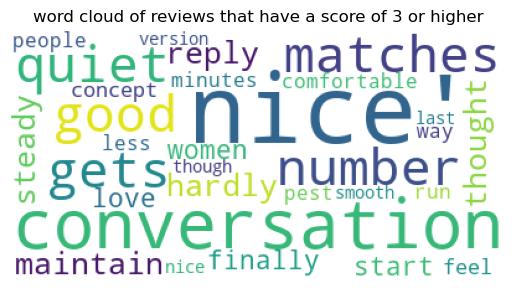

In [35]:
wordcloud_good = WordCloud(stopwords = stop, max_words = 300, background_color='white').generate(text_good)
plt.title('word cloud of reviews that have a score of 3 or higher')
plt.axis('off')
plt.imshow(wordcloud_good)
plt.show()

The majority of good reviews seem to talk about the matches and conversations, that it is nice (possible the app feels nice, or meet nice people). The word women came up too, possibly underlining that women need to start the messaging.

the word cloud interpretation could not be precise and only looking at the comment adn running a thematic analysis is possible to better understand the comments. A sentiment analysis could also be run. 